# Experiment 4
This experiment adds data augmentation to the experiment 3 model.

In [1]:
# model training using tensorflow
import numpy as np
import os
import cv2
from matplotlib import pyplot

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
'''
Configuration Code
'''
def get_n_cores():
    """The NSLOTS variable, If NSLOTS is not defined throw an exception."""
    nslots = os.getenv("NSLOTS")
    if nslots is not None:
        return int(nslots)
    raise ValueError("Environment variable NSLOTS is not defined.")


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

NUM_GPUS = len(tf.config.experimental.list_physical_devices("GPU"))
print("Num GPUs Available: ", NUM_GPUS)
if NUM_GPUS > 0:
    print(os.getenv("CUDA_VISIBLE_DEVICES"))

tf.config.set_soft_device_placement(True)
tf.keras.backend.set_floatx("float32")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(get_n_cores())

Num GPUs Available:  1
0


In [3]:
batch_size = 32

DATA_DIRECTORY = os.path.join(os.getcwd(), 'train_data')

size = (224,224) # height, width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 2160 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 540 files for validation.


In [6]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3))

In [5]:
'''
Data augmentation layer
'''
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

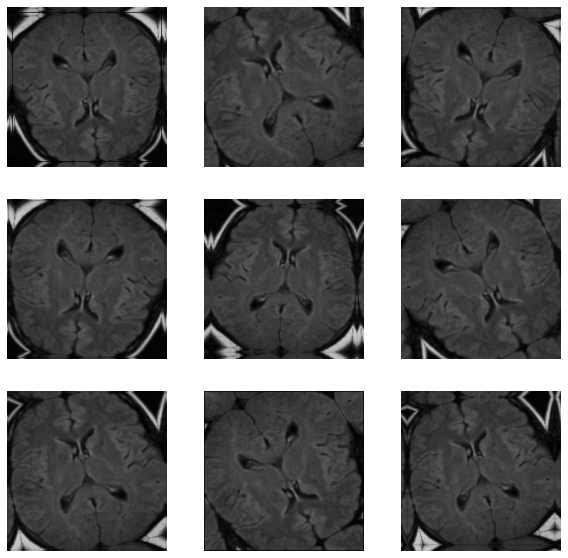

In [7]:
'''
Plot some of the augmented images
 - this shows how the images could be augmented, with flips and rotations
'''
pyplot.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = pyplot.subplot(3, 3, i + 1)
        pyplot.imshow(augmented_images[0].numpy().astype("uint8"))
        pyplot.axis("off")

In [8]:
num_classes = 2

model = Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [9]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
 )

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [11]:
epochs=100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/100
68/68 [==============================] - 6s 89ms/step - loss: 0.7355 - accuracy: 0.5639 - val_loss: 0.6602 - val_accuracy: 0.5907
Epoch 2/100
68/68 [==============================] - 5s 76ms/step - loss: 0.5964 - accuracy: 0.6778 - val_loss: 0.5577 - val_accuracy: 0.7500
Epoch 3/100
68/68 [==============================] - 5s 74ms/step - loss: 0.5481 - accuracy: 0.7171 - val_loss: 0.5489 - val_accuracy: 0.7444
Epoch 4/100
68/68 [==============================] - 5s 77ms/step - loss: 0.4861 - accuracy: 0.7667 - val_loss: 0.4608 - val_accuracy: 0.7833
Epoch 5/100
68/68 [==============================] - 5s 79ms/step - loss: 0.4661 - accuracy: 0.7819 - val_loss: 0.4300 - val_accuracy: 0.8148
Epoch 6/100
68/68 [==============================] - 5s 77ms/step - loss: 0.4243 - accuracy: 0.8019 - val_loss: 0.4249 - val_accuracy: 0.8148
Epoch 7/100
68/68 [==============================] - 6s 83ms/step - loss: 0.4300 - accuracy: 0.7898 - val_loss: 0.5182 - val_accuracy: 0.8037
Epoch 

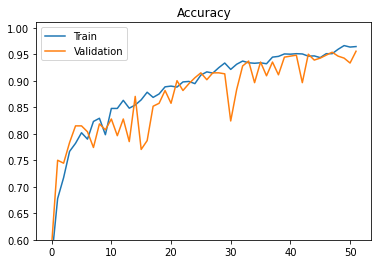

In [14]:
'''
Plot the accuracy
'''
pyplot.title("Accuracy")
pyplot.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = "Train")
pyplot.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = "Validation")
pyplot.ylim((0.6,1.01))
pyplot.legend()
pyplot.show()

In [15]:
model.save('models/experiment_004')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/experiment_004/assets
